<a href="https://colab.research.google.com/github/pradeep-016/Multimodal/blob/main/Mulit_Model_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Embedding, concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load CIFAR-10 dataset
(x_train_images, y_train_images), (x_test_images, y_test_images) = cifar10.load_data()
x_train_images = x_train_images.astype('float32') / 255.0
x_test_images = x_test_images.astype('float32') / 255.0

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
# Load IMDb dataset
max_features = 10000  # Consider the top N most frequent words
maxlen = 100  # Cut texts after this number of words (among top max_features most common words)
(x_train_text, y_train_text), (x_test_text, y_test_text) = imdb.load_data(num_words=max_features)
x_train_text = pad_sequences(x_train_text, maxlen=maxlen)
x_test_text = pad_sequences(x_test_text, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
# Ensure the same number of samples for both image and text data
num_samples = min(x_train_images.shape[0], x_train_text.shape[0])
x_train_images = x_train_images[:num_samples]
x_train_text = x_train_text[:num_samples]
y_train = y_train_text[:num_samples]

In [5]:
# Split the data into training and validation sets
x_train_images, x_val_images, x_train_text, x_val_text, y_train, y_val = train_test_split(
x_train_images, x_train_text, y_train, test_size=0.2, random_state=42)

In [6]:
# Define input shapes
image_input_shape = (32, 32, 3)  # Shape of CIFAR-10 images
text_input_shape = (maxlen,)      # Shape of text data (e.g., sequences of length 100)

In [7]:
# Define CNN model for image processing
image_input = Input(shape=image_input_shape)
conv1 = Conv2D(32, (3, 3), activation='relu')(image_input)
maxpool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)
flatten_image = Flatten()(maxpool2)

cnn_model = Model(inputs=image_input, outputs=flatten_image)

In [8]:
# Define RNN model for text processing
text_input = Input(shape=text_input_shape)
embedding = Embedding(input_dim=max_features, output_dim=128)(text_input)
reshape_text = Reshape((maxlen, 128, 1))(embedding)  # Add a channel dimension for compatibility with Conv2D
conv_text = Conv2D(32, (3, 3), activation='relu')(reshape_text)
maxpool_text = MaxPooling2D((2, 2))(conv_text)
flatten_text = Flatten()(maxpool_text)

rnn_model = Model(inputs=text_input, outputs=flatten_text)

In [9]:
# Concatenate the outputs of CNN and RNN models
combined_output = concatenate([cnn_model.output, rnn_model.output])

In [10]:
# Add a fully connected layer for classification
dense1 = Dense(128, activation='relu')(combined_output)
output = Dense(1, activation='sigmoid')(dense1)  # Binary classification for IMDb dataset

In [11]:
# Create the final multi-model architecture
multi_model = Model(inputs=[image_input, text_input], outputs=output)

In [12]:
# Compile the model
multi_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Display model summary
multi_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 30, 30, 32)           896       ['input_1[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 100, 128)             1280000   ['input_2[0][0]']             
                                                                                            

In [14]:
# Train the model (example)
history = multi_model.fit([x_train_images, x_train_text], y_train, epochs=15, batch_size=64, validation_data=([x_val_images, x_val_text], y_val))

Epoch 1/15
313/313 [==============================] - 26s 61ms/step - loss: 0.4850 - accuracy: 0.7316 - val_loss: 0.3223 - val_accuracy: 0.8570
Epoch 2/15
313/313 [==============================] - 8s 27ms/step - loss: 0.2048 - accuracy: 0.9211 - val_loss: 0.3544 - val_accuracy: 0.8472
Epoch 3/15
313/313 [==============================] - 7s 24ms/step - loss: 0.0344 - accuracy: 0.9913 - val_loss: 0.5075 - val_accuracy: 0.8352
Epoch 4/15
313/313 [==============================] - 7s 23ms/step - loss: 0.0032 - accuracy: 0.9997 - val_loss: 0.6363 - val_accuracy: 0.8382
Epoch 5/15
313/313 [==============================] - 7s 22ms/step - loss: 3.4865e-04 - accuracy: 1.0000 - val_loss: 0.6693 - val_accuracy: 0.8414
Epoch 6/15
313/313 [==============================] - 6s 21ms/step - loss: 1.5752e-04 - accuracy: 1.0000 - val_loss: 0.6991 - val_accuracy: 0.8412
Epoch 7/15
313/313 [==============================] - 7s 21ms/step - loss: 1.0057e-04 - accuracy: 1.0000 - val_loss: 0.7224 - val_acc

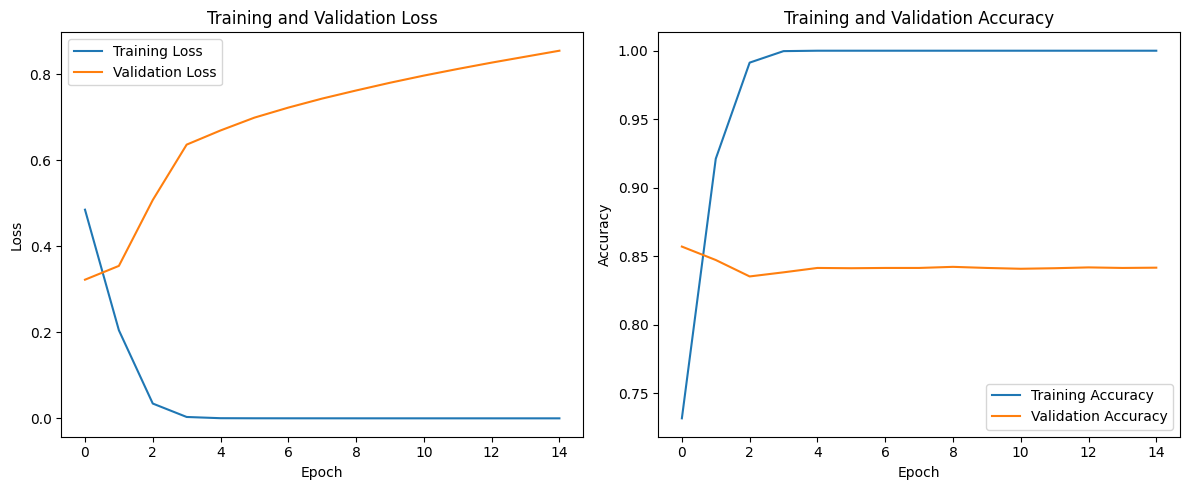

In [15]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
5
plt.tight_layout()
plt.show()

In [16]:
# Assuming x_test_text has 25000 samples and x_test_images has 10000 samples
# Adjust the number of samples in x_test_images to match the number of samples in x_test_text
num_samples = min(x_test_images.shape[0], x_test_text.shape[0])
x_test_images = x_test_images[:num_samples]
x_test_text = x_test_text[:num_samples]

# Make predictions on test data in batches
batch_size = 64
predictions = []
for i in range(0, num_samples, batch_size):
    batch_x_images = x_test_images[i:i+batch_size]
    batch_x_text = x_test_text[i:i+batch_size]
    batch_predictions = multi_model.predict([batch_x_images, batch_x_text])
    predictions.extend(batch_predictions)

predictions = np.array(predictions)


1/1 [==============================] - 0s 255ms/step


In [17]:
from sklearn.metrics import accuracy_score

# Convert probabilities to binary labels
binary_predictions = (predictions > 0.5).astype(int)  # Adjust the threshold if needed

# Calculate accuracy score
accuracy = accuracy_score(y_test_text[:num_samples], binary_predictions)
print("Accuracy on test data:", accuracy)


Accuracy on test data: 0.8379
